# Detecting heart arrythmias using anomaly detection
## Yngve Mardal Moe

In [132]:
import requests
import io
import itertools
from pprint import pprint
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

%matplotlib notebook

/home/yngve/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Let us prepare the dataset
This is a famous arrythmia dataset, the original task was to detect arrythmias. However, it has been modified so the task at hand is to detect a collection of very rare arrythmias instead.

In [213]:
def load_csv_from_url(url, header='infer'):
    csv_str = requests.get(url).content.decode('utf-8')
    return pd.read_csv(io.StringIO(csv_str), index_col=0, header=header)

X = pd.read_csv('export.csv', index_col=0)
X.index = X.index.to_datetime()

y = X['Maksimum lufttemperatur i 2m hoyde (TX)']

start_train = y.index[0]
end_train = y.index[len(y)//2]
start_test = y.index[len(y)//2]
end_test = y.index[-1]
y_train = y[start_train:end_train]
y_test = y[start_test:end_test]

/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


In [217]:
arma = sm.tsa.SARIMAX(y_train, order=(10, 0, 0))
results = arma.fit()

test_model = sm.tsa.SARIMAX(y_test, order=(10, 0, 0))
test_results = new_model.smooth(results.params)

MAE_train = np.abs(results.predict() - y_train).mean()
MAE_test = np.abs(test_results.predict() - y_test).mean()

print(f'The mean average error for the training set is {MAE_train}')
print(f'The mean average error for the test set is {MAE_test}')

The mean average error for the training set is 1.8844867216194532
The mean average error for the test set is 2.0995793155719706


<IPython.core.display.Javascript object>


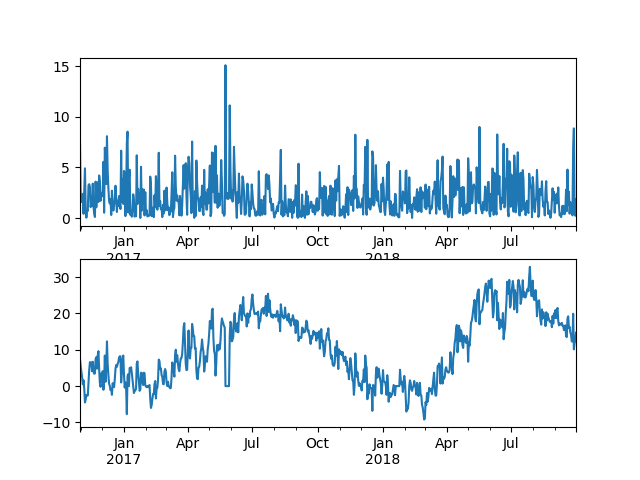

In [218]:
plt.figure()
plt.subplot(211)
np.abs(new_results.predict() - y_test).plot()
plt.subplot(212)
y_test.plot()